In [73]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow_probability as tfp

import sys
sys.path.append('/Users/jay/Desktop/Bachelorarbeit/Implementation')
from dependencies.hbv_sask.model import HBVSASKModel as hbvmodel
from dependencies.PyDREAM.pydream.parameters import SampledParam



TIME_COLUMN_NAME = 'TimeStamp'
INDEX_COLUMN_NAME = "Index_run"
PLOT_FORCING_DATA = True
PLOT_ALL_THE_RUNS = True
QOI_COLUMN_NAME = "model"  # "Value"
MODEL = 'hbv-sask'  #'hbv-sask' # 'banchmark_model' or 'simple_model' or 'hbv-sask'
QOI_COLUMN_NAME = "Q_cms"
QOI_COLUM_NAME_MESURED = "streamflow"

ndims = 7
dims_c = ['TT', 'C0', 'beta', 'ETF', 'FC', 'FRAC', 'K2']
dims_enum = []
dims = []
for i in range(5):
    dims_t = dims_c.copy()
    for j in range(len(dims_t)):
        dims_t[j] = dims_t[j] + f'_{str(i + 1)}'
        dims.append(dims_t[j])
    dims_enum.append(dims_t)
colors = sns.color_palette(n_colors=ndims)

# Measured Data (TODO: measure data)
measured_data = np.array([9.50, 9.18, 8.85, 7.78, 7.01, 7.53, 7.31, 6.76, 6.60, 7.07, 9.94, 10.70, 9.58, 8.53, 8.86, 8.73, 10.10, 9.72, 10.30, 10.50, 10.30, 9.99, 9.65, 10.10, 10.30, 12.50, 15.10, 16.30, 17.00, 22.80, 27.00, 26.20])

In [2]:
# Defining paths and Creating Model Object
hbv_model_data_path = pathlib.Path("../../dependencies/hbv_sask/data/")
configurationObject = pathlib.Path('/Users/jay/Desktop/Bachelorarbeit/Implementation/configurations/configuration_hbv_6D.json')
inputModelDir = hbv_model_data_path
basis = "Oldman_Basin"  # 'Banff_Basin'
workingDir = hbv_model_data_path / basis / "model_runs" / "running_the_model_parallel_simple"

# creating HBVSASK model object
writing_results_to_a_file = False
plotting = False
createNewFolder = False  # create a separate folder to save results for each model run
model = hbvmodel.HBVSASKModel(
    configurationObject=configurationObject,
    inputModelDir=inputModelDir,
    workingDir=workingDir,
    basis=basis,
    writing_results_to_a_file=writing_results_to_a_file,
    plotting=plotting
)

directory_for_saving_plots = workingDir
if not str(directory_for_saving_plots).endswith("/"):
    directory_for_saving_plots = str(directory_for_saving_plots) + "/"

# =========================================================
# Time related set-up; relevant for more complex models
# =========================================================
# In case one wants to modify dates compared to those set up in the configuration object / deverge from these setting
# if not, just comment out this whole part 
start_date = '2006-03-30 00:00:00'
end_date = '2007-04-30 00:00:00'
spin_up_length = 365  # 365*3
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
# dict_with_dates_setup = {"start_date": start_date, "end_date": end_date, "spin_up_length":spin_up_length}
run_full_timespan = False
model.set_run_full_timespan(run_full_timespan)
model.set_start_date(start_date)
model.set_end_date(end_date)
model.set_spin_up_length(spin_up_length)
simulation_length = (model.end_date - model.start_date).days - model.spin_up_length
if simulation_length <= 0:
    simulation_length = 365
model.set_simulation_length(simulation_length)
model.set_date_ranges()
model.redo_input_and_measured_data_setup()

    

In [64]:
def run_model_single_parameter_node(model, parameter_value_dict, unique_index_model_run=0, qoi_column_name=QOI_COLUMN_NAME, qoi_column_name_measured=QOI_COLUM_NAME_MESURED, **kwargs):
    # take_direct_value should be True if parameter_value_dict is a dict with keys being paramter name and values being parameter values;
    # if parameter_value_dict is a list of parameter values corresponding to the order of the parameters in the configuration file, then take_direct_value should be False
    # it is assumed that model is a subclass of HydroModel from UQEF-Dynamic
    results_list = model.run(
        i_s=[unique_index_model_run, ],
        parameters=[parameter_value_dict, ],
        createNewFolder=False,
        take_direct_value=True,
        merge_output_with_measured_data=True,
    )
    # extract y_t produced by the model
    y_t_model = results_list[0][0]['result_time_series'][qoi_column_name].to_numpy()
    if qoi_column_name_measured is not None and qoi_column_name_measured in results_list[0][0]['result_time_series']:
        y_t_observed = results_list[0][0]['result_time_series'][qoi_column_name_measured].to_numpy()
        # y_t_observed = model.time_series_measured_data_df[qoi_column_name_measured].values
    else:
        y_t_observed = None  
    return unique_index_model_run, y_t_model, y_t_observed, parameter_value_dict

# Construct params
configurationObject = model.configurationObject
param_names = []
param_lower = []
param_upper = []
for param in configurationObject["parameters"]:
    # for now the Uniform distribution is only supported
    if param["distribution"] == "Uniform":
        param_names.append(param["name"])
        param_lower.append(param["lower"])
        param_upper.append(param["upper"])
    else:
        raise NotImplementedError(f"Sorry, the distribution {param['distribution']} is not supported yet")
param_lower = np.array(param_lower)
param_upper = np.array(param_upper)


def displot(i, data, chain_num):
    # Plot sampled distribution
    params = []
    for j in range(chain_num):
        params.append(dims[i + 7 * j])
    print(params)
   
    _, ax = plt.subplots()
    for j in range(chain_num):
        sns.kdeplot(data = data[params[j]], ax=ax)
    plt.show()

    # Plot distribution that is sampled from
    #uni = uniform(loc=param_lower[i], scale=param_upper[i] - param_lower[i])
    #uni = tfp.distributions.Uniform(low=param_lower[i], high=param_upper[i])
    #x = np.linspace(param_lower[i], param_upper[i], 25000)
    #y = uni.prob(x)

    # Configuration
    #plt.plot(x, y, label='pdf', color='grey')
    #plt.title(f'PDF of parameter {dims[i]}')
    #plt.show()

def boxplot(i, data):
    sns.boxplot(data, x=dims[i], color=colors[i])
    plt.title(f'Boxplot of parameter {dims[i]}')


In [4]:
samples = pd.read_csv('../notebook_data/sep_analysis.out')
samples

,TT_1,C0_1,beta_1,ETF_1,FC_1,FRAC_1,K2_1,TT_2,C0_2,beta_2,...,FC_4,FRAC_4,K2_4,TT_5,C0_5,beta_5,ETF_5,FC_5,FRAC_5,K2_5
0,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392,1.506320,2.230529,1.016460,...,327.366973,0.131457,0.012662,0.630885,1.477826,2.457048,0.783218,405.538337,0.102221,0.092732
1,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392,1.506320,2.230529,1.016460,...,327.366973,0.131457,0.012662,0.630885,1.477826,2.457048,0.783218,405.538337,0.102221,0.092732
2,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392,1.506320,2.230529,1.016460,...,377.380746,0.129926,0.011998,0.630885,1.477826,2.457048,0.783218,405.538337,0.102221,0.092732
3,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392,1.506320,2.230529,1.016460,...,377.380746,0.129926,0.011998,0.630885,1.433834,2.251050,0.876404,405.538337,0.102221,0.090253
4,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392,1.506320,2.230529,1.016460,...,377.380746,0.129926,0.011998,0.630885,1.433834,2.251050,0.876404,405.538337,0.102221,0.090253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.965460,2.825195,1.047050,0.111805,986.750002,0.134546,0.030197,1.484324,0.799267,1.286336,...,547.767906,0.136589,0.021708,2.660818,3.919432,2.076633,0.545546,348.473274,0.103780,0.025141
4996,1.965460,2.825195,1.047050,0.111805,986.750002,0.141062,0.030197,1.484324,0.799267,1.286336,...,532.134413,0.134983,0.020695,2.660818,3.919432,2.076633,0.522386,338.176124,0.104067,0.026409
4997,1.965460,2.825195,1.047050,0.111805,986.750002,0.141062,0.030197,1.484324,0.799267,1.286336,...,555.261495,0.132348,0.020695,2.660818,3.919432,2.076633,0.522386,338.176124,0.104067,0.026409
4998,1.965460,2.825195,1.047050,0.111805,986.750002,0.141062,0.030197,1.484324,0.799267,1.286336,...,555.261495,0.132348,0.020695,2.660818,3.919432,2.076633,0.522386,338.176124,0.104067,0.026409


# Plotting

['TT_1', 'TT_2', 'TT_3', 'TT_4', 'TT_5']


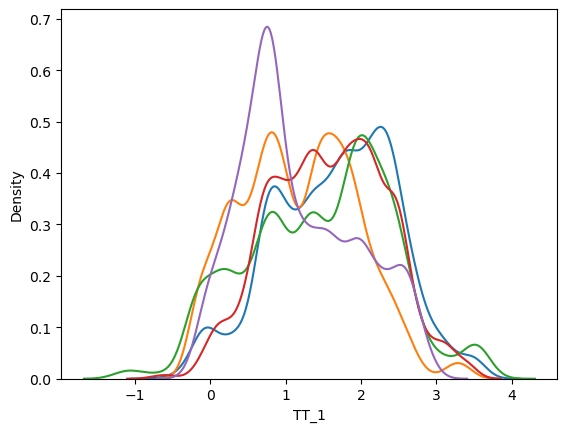

In [65]:
# Plot TT
displot(0, samples, 5)

['C0_1', 'C0_2', 'C0_3', 'C0_4', 'C0_5']


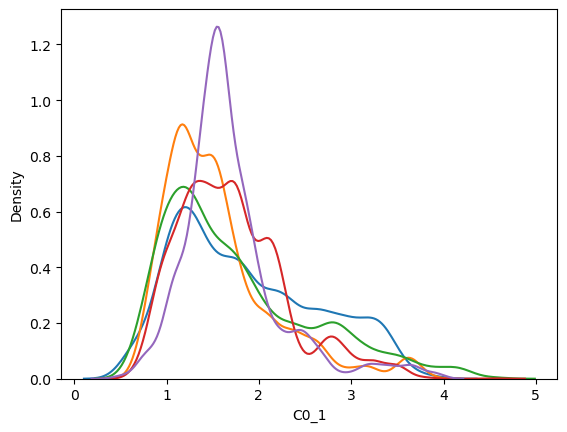

In [66]:
# Plot TT
displot(1, samples, 5)

['beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5']


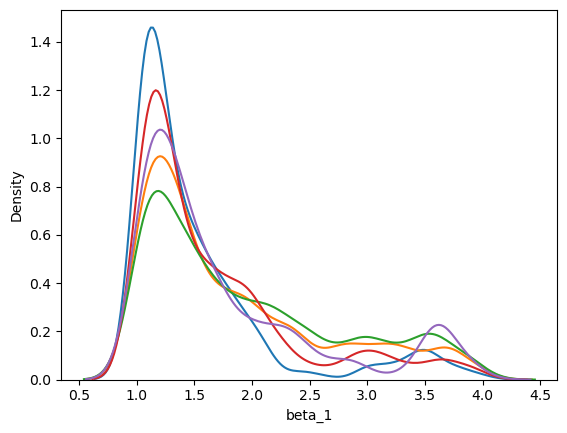

In [67]:
# Plot TT
displot(2, samples, 5)

['ETF_1', 'ETF_2', 'ETF_3', 'ETF_4', 'ETF_5']


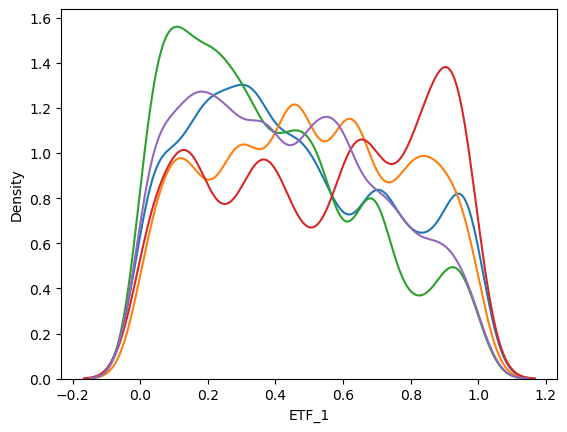

In [69]:
displot(3, samples, 5)

['FC_1', 'FC_2', 'FC_3', 'FC_4', 'FC_5']


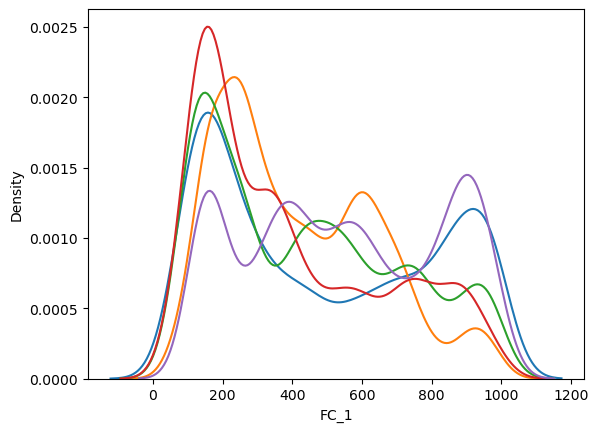

In [70]:
displot(4, samples, 5)

['FRAC_1', 'FRAC_2', 'FRAC_3', 'FRAC_4', 'FRAC_5']


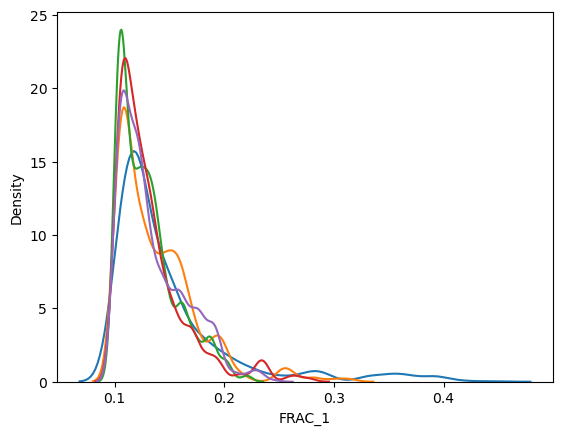

In [71]:
displot(5, samples, 5)

['K2_1', 'K2_2', 'K2_3', 'K2_4', 'K2_5']


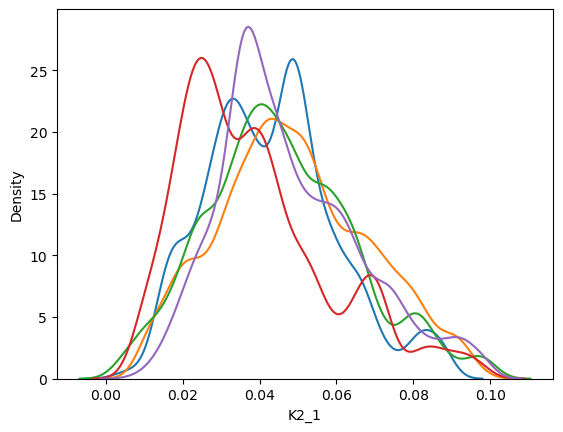

In [72]:
displot(6, samples, 5)

# Sampling

In [78]:
samples[dims_enum[0]]

,TT_1,C0_1,beta_1,ETF_1,FC_1,FRAC_1,K2_1
0,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392
1,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392
2,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392
3,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392
4,2.168593,0.891215,3.149545,0.028472,97.283761,0.202334,0.025392
...,...,...,...,...,...,...,...
4995,1.965460,2.825195,1.047050,0.111805,986.750002,0.134546,0.030197
4996,1.965460,2.825195,1.047050,0.111805,986.750002,0.141062,0.030197
4997,1.965460,2.825195,1.047050,0.111805,986.750002,0.141062,0.030197
4998,1.965460,2.825195,1.047050,0.111805,986.750002,0.141062,0.030197


In [79]:
# Sampling Max from Posterior
sampled_max_s = []
for dim in dims_enum:
    param_vec = []
    for i in range(7):
        values, counts = np.unique(samples[dim].iloc[:, i], return_counts=True)
        ind = np.argmax(counts)
        param_vec.append(values[ind])

    _, sampled_max, _, _ = run_model_single_parameter_node(model, param_vec)
    sampled_max_s.append(sampled_max)

[HVBSASK INFO] [0] parameters: [[0.7225713688495298, 1.7726349176840148, 1.0829038054488365, 0.12701776167697007, 92.25843696626383, 0.1198690115733411, 0.031744303417904844]]
[HVBSASK INFO] [0] parameters: [[1.4101234260177056, 1.1487235422106294, 2.842689881845218, 0.6152839565368616, 154.9699979153152, 0.14411607757044728, 0.011060833525586856]]
[HVBSASK INFO] [0] parameters: [[0.8990491818368936, 1.0949982786954375, 2.447782455071456, 0.3956712068996608, 145.5744489272493, 0.10457916301542108, 0.056078113242887785]]
[HVBSASK INFO] [0] parameters: [[2.471854000739552, 1.4299309666488476, 1.1675031826316848, 0.32510541638792156, 135.27158381845135, 0.13000677776335795, 0.024288468534652243]]
[HVBSASK INFO] [0] parameters: [[2.572736023136486, 1.396633913204819, 1.205764451712167, 0.3660093187512596, 896.1581864540367, 0.10944449599734767, 0.03601399485750504]]


In [84]:
# Mean Sampling from Posterior
sampled_column_means_s = []

for dim in dims_enum:
    sample_param = []
    for i in range(7):
        sample_param.append(np.random.choice(samples[dim].iloc[:, i], 1000))
    sample_param = np.array(sample_param).T

    all_results = []
    for _, vec in enumerate(sample_param):
        _, y_model, _, _ = run_model_single_parameter_node(model, np.array(vec))
        all_results.append(y_model)

    sampled_column_means = np.mean(np.array(all_results), axis=0) 
    sampled_column_means_s.append(sampled_column_means)

[HVBSASK INFO] [0] parameters: [array([2.22923582e+00, 1.57122608e+00, 1.19500547e+00, 4.44373752e-01,
       2.12068219e+02, 2.79597271e-01, 5.12350137e-02])]
[HVBSASK INFO] [0] parameters: [array([2.54842918e+00, 1.52739760e+00, 1.50156635e+00, 2.51132695e-01,
       1.02513291e+02, 1.18651434e-01, 3.17443034e-02])]
[HVBSASK INFO] [0] parameters: [array([2.08197921e+00, 1.49460935e+00, 1.10118263e+00, 4.78480817e-01,
       8.75251704e+02, 1.20350518e-01, 4.55467655e-02])]
[HVBSASK INFO] [0] parameters: [array([1.10744659e+00, 2.49427689e+00, 1.11095238e+00, 9.16931871e-01,
       7.98182927e+02, 1.77183200e-01, 1.44609392e-02])]
[HVBSASK INFO] [0] parameters: [array([1.03579423e+00, 3.09650167e+00, 1.22569687e+00, 3.31092733e-01,
       3.11655909e+02, 2.55557870e-01, 3.41650370e-02])]
[HVBSASK INFO] [0] parameters: [array([1.72938258e+00, 1.57216858e+00, 1.93449392e+00, 1.87833562e-01,
       6.08454207e+02, 2.03868000e-01, 3.80452618e-02])]
[HVBSASK INFO] [0] parameters: [array([2

In [86]:
# Mean Sampling from Prior
sample_param = []
for i in range(7):
    #uni = uniform.rvs(loc=param_lower[i], scale=param_upper[i] - param_lower[i], size=1000)
    uni = tfp.distributions.Uniform(low=param_lower[i], high=param_upper[i]).sample(1)
    sample_param.append(uni)
sample_param = np.array(sample_param).T

all_results = []
for _, vec in enumerate(sample_param):
    _, y_model, _, _ = run_model_single_parameter_node(model, np.array(vec))
    all_results.append(y_model)

start_column_means = np.mean(np.array(all_results), axis=0)
    

[HVBSASK INFO] [0] parameters: [array([2.89719183e+00, 1.77762817e+00, 2.15701752e+00, 8.12888448e-01,
       8.35689109e+01, 6.44923033e-01, 5.26549081e-02])]


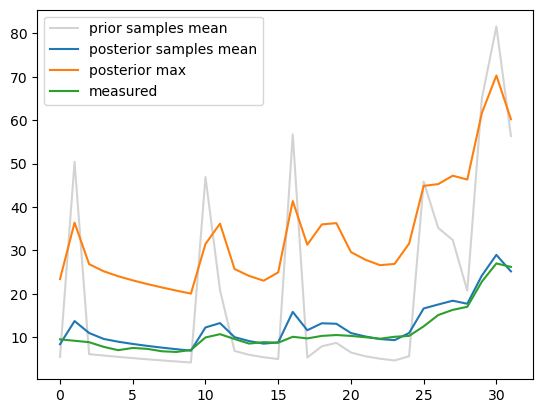

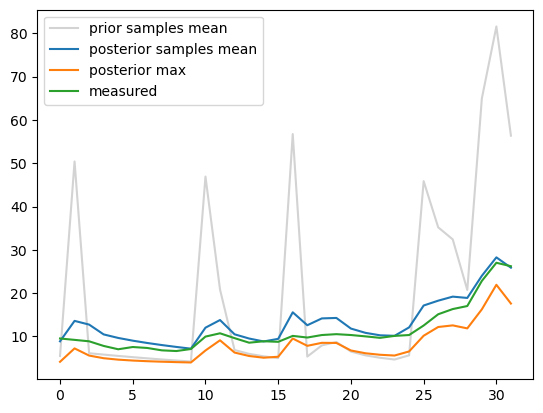

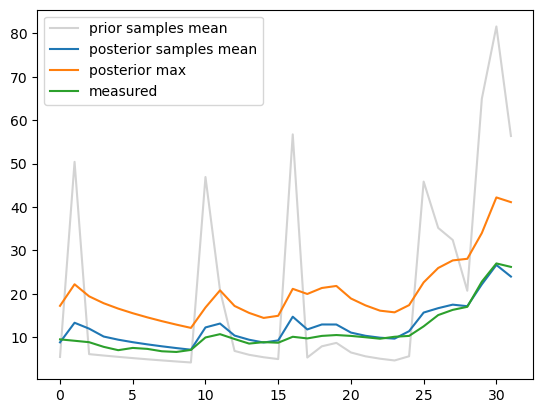

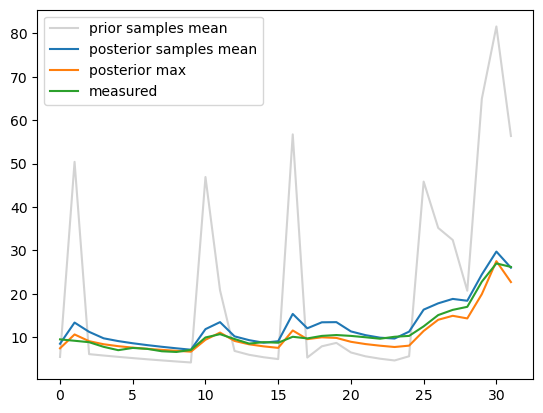

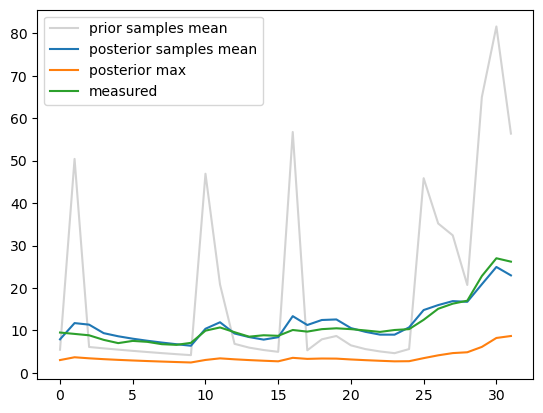

In [87]:
for i in range(len(dims_enum)):
    fig = plt.figure()
    plt.plot(start_column_means, label='prior samples mean', color='lightgrey')
    plt.plot(sampled_column_means_s[i], label='posterior samples mean')
    plt.plot(sampled_max_s[i], label='posterior max')
    plt.plot(measured_data, label='measured')
    plt.legend()
    plt.show()